In [220]:
# Appropriate imports
import torch
import numpy as np

In [235]:
class PhysistsCar():
    '''
    To a physist everything is a 3-dimensional object:
    The physical time
    The position at that time
    The velocity at that time

    Then everything is determined by Newton's Law.
    PhysistsCar assings 3 such attributes.
    and implements a .step() method which simulates one timestep's evolution.
    '''
    def __init__(self, init_pos, init_vel, init_time = 0, dt = 0.01):
        self.time = init_time
        self.pos = init_pos
        self.vel = init_vel
        self.dt = dt
        self.distance_log = []
        
    def step(self, acc):
        self.time += self.dt
        self.pos += self.vel * self.dt
        self.vel += acc * self.dt
        self.distance_log.append( torch.sqrt( self.pos ** 2 + self.vel**2 ) )

In [237]:
init_pos = torch.tensor([1., 2., 3., 4., 5.])
init_vel = torch.tensor([5., 4., 3., 2., 1.])
strategy = torch.rand(1000,)
car = PhysistsCar(init_pos, init_vel)
Simul = CarSimulator(car, strategy)
Simul.simul()

In [252]:
torch.set_default_dtype(torch.double)
torch.manual_seed(2048)

import torch.nn as nn
class EndtimeGuess(nn.Module):
    """ Naive MLP model.
    Input: Initial configuration
    Output: Endtime Guess
    """
    def __init__(self):
        super().__init__()
        layers = []
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            )
        
    def forward(self, init_pos, init_vel):
        init_phase = torch.stack( (init_pos, init_vel), dim = -1)
        return torch.sigmoid(self.net(init_phase))

    
def strategy_cutoff(init_pos, init_vel, switching_time, N, dt, sharpness = 20):
    def logistic(x):
        return 1/(1+torch.exp(-sharpness * x))
    
    sign_init = - 2 * ( (logistic(init_vel) * logistic(init_pos + init_vel**2/2) 
                 + logistic(-init_vel) * logistic(init_pos - init_vel**2/2) ) ) + 1
    mask = logistic ( -(torch.arange(N).reshape(1, -1) * dt) + switching_time.reshape(-1, 1) )
    sign = 2*mask - 1
    return (sign_init.reshape(-1, 1) * sign)

# Physics
def physics_simul(init_pos, lint_vel, Strategy, N, dt):
    M_ij = torch.arange(N).view(-1, 1) - torch.arange(N).view(1, -1) - 1/2
    M_ij = M_ij * (M_ij > 0)
    acc_part = torch.einsum('ij, bj -> bi', M_ij, Strategy)
    vel_part = init_vel
    history_pos = dt**2 * acc_part + dt * init_vel.view(-1, 1) * torch.arange(N).view(1, -1) + init_pos.view(-1, 1)
    history_vel = dt * torch.cumsum(Strategy, dim = 1) + init_vel.view(-1, 1)
    return history_pos, history_vel
    

In [253]:
N = 1000
t_final = 24
dt = t_final/N

model = EndtimeGuess()

In [255]:
from torch.optim import Optimizer
train_steps = 12000

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
init_pos_max = 10
init_pos_min = -10
init_vel_max = 5
init_vel_min = -5
batch_size = 64
beta = 12.
lamda = 1.

import time
tic = time.time()

for step in range(train_steps):
    init_pos = torch.rand(batch_size,) * (init_pos_max-init_pos_min) + init_pos_min
    init_vel = torch.rand(batch_size,) * (init_vel_max-init_vel_min) + init_vel_min
    
    switching_time = model(init_pos, init_vel) * t_final
    Strategy = strategy_cutoff(init_pos, init_vel, switching_time, N, dt)
    history_pos, history_vel = physics_simul(init_pos, init_vel, Strategy, N, dt)
    history = history_pos ** 2 + history_vel ** 2
    optimizer.zero_grad()
    loss = - torch.mean( torch.logsumexp( -beta * history, dim = 1) , dim = 0 )
    loss.backward()

    # perform SGD step (parameter update)
    optimizer.step()
    
    if step % 200 == 0:
        print(f"step = {step}, loss = {loss}, switching_time_mean = {switching_time.mean()}")
  
toc = time.time()
print(f"Time ellapsed in training is: {toc-tic}")


step = 0, loss = 169.335629299882, switching_time_mean = 16.91494126337571
step = 200, loss = 189.4895865439137, switching_time_mean = 18.723095451860736
step = 400, loss = 177.44040718394234, switching_time_mean = 14.813351031662483
step = 600, loss = 170.77255110513414, switching_time_mean = 18.395534004277582
step = 800, loss = 176.3479805440716, switching_time_mean = 22.184642302745274
step = 1000, loss = 187.1398300385324, switching_time_mean = 22.04340823836467
step = 1200, loss = 182.3923936734974, switching_time_mean = 21.59898120160787
step = 1400, loss = 179.30526756639125, switching_time_mean = 22.198054682573645
step = 1600, loss = 160.7830901763374, switching_time_mean = 21.2370916001717
step = 1800, loss = 157.07691770064918, switching_time_mean = 21.055032218186028
step = 2000, loss = 170.91975821895647, switching_time_mean = 20.95760452454129
step = 2200, loss = 165.80391139040628, switching_time_mean = 20.698292115485756
step = 2400, loss = 164.9087559673879, switching

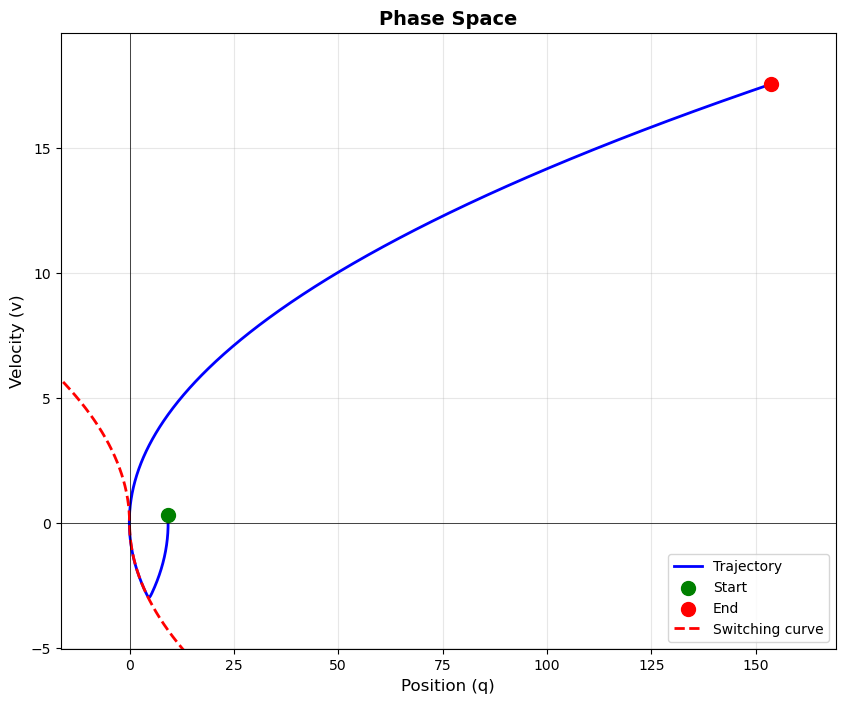

In [259]:
import matplotlib.pyplot as plt

b = 44

fig, ax1 = plt.subplots(figsize=(10, 8))
pos = history_pos[b].detach().numpy()
vel = history_vel[b].detach().numpy()

x_min, x_max = pos.min(), pos.max()
y_min, y_max = vel.min(), vel.max()

x_min = min(x_min, -1.0)  # At least show -1 if everything is positive
x_max = max(x_max, 1.0)   # At least show +1 if everything is negative
y_min = min(y_min, -1.0)
y_max = max(y_max, 1.0)

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax1.set_xlim(x_min - x_margin, x_max + x_margin)
ax1.set_ylim(y_min - y_margin, y_max + y_margin)

ax1.plot(pos, vel, 'b-', linewidth=2, label='Trajectory')
ax1.scatter(pos[0], vel[0], color='green', s=100, zorder=5, label='Start')
ax1.scatter(pos[-1], vel[-1], color='red', s=100, zorder=5, label='End')

# 스위칭 곡선: v^2/2 + q = 0 => q = -v^2/2
v_switch = np.linspace(-15, 15, 500)
q_switch = -v_switch * np.abs(v_switch) / 2
ax1.plot(q_switch, v_switch, 'r--', linewidth=2, label='Switching curve')

ax1.set_xlabel('Position (q)', fontsize=12)
ax1.set_ylabel('Velocity (v)', fontsize=12)
ax1.set_title('Phase Space', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
plt.show()

In [257]:
def switching_time_benchmark(init_pos, init_vel):
    def time_for_upper(init_pos, init_vel):
        return init_vel + torch.sqrt(init_vel**2/2 + init_pos)
    mask = 2*init_pos + init_vel * torch.abs(init_vel) >=0
    sign = 2*mask - 1
    mod_vel = sign * init_vel
    mod_pos = sign * init_pos
    return time_for_upper(mod_pos, mod_vel)

tensor([3.6484, 5.7636, 5.3041, 5.4235, 3.4999, 7.0422, 8.5579, 7.4512, 3.7259,
        7.0443, 1.9381, 7.5835, 5.1585, 6.6454, 8.1112, 5.3082, 3.0173, 1.2888,
        4.6453, 1.4121, 7.6884, 0.0795, 1.0990, 0.1074, 7.2463, 4.1140, 5.5800,
        6.3704, 0.4297, 2.7694, 8.2646, 4.8485, 8.2139, 8.3438, 8.4207, 1.9710,
        7.3631, 5.0162, 9.5075, 7.8937, 6.4036, 1.2581, 5.4471, 3.8286, 3.3789,
        5.3756, 5.9358, 0.0675, 0.8908, 1.7558, 8.0539, 7.8423, 4.0281, 4.2395,
        3.2380, 8.3729, 5.8774, 5.6341, 3.4566, 5.9166, 1.6347, 1.9838, 6.7747,
        0.2506])
tensor([3.4499, 5.7265, 5.3008, 5.3934, 3.5072, 7.0245, 8.5507, 7.4271, 3.7348,
        6.9944, 1.8748, 7.4719, 5.1278, 6.5324, 8.0942, 5.2998, 2.9863, 1.3189,
        1.0766, 1.3514, 7.6362, 2.0111, 0.9894, 1.0112, 7.2054, 4.0504, 5.5428,
        6.3681, 0.3489, 2.7537, 8.2506, 4.8399, 8.2059, 8.3072, 8.3745, 1.9804,
        7.3155, 5.0258, 9.4364, 7.7740, 6.3360, 1.2376, 5.4215, 3.8220, 3.3770,
        5.2481, 5.9404,

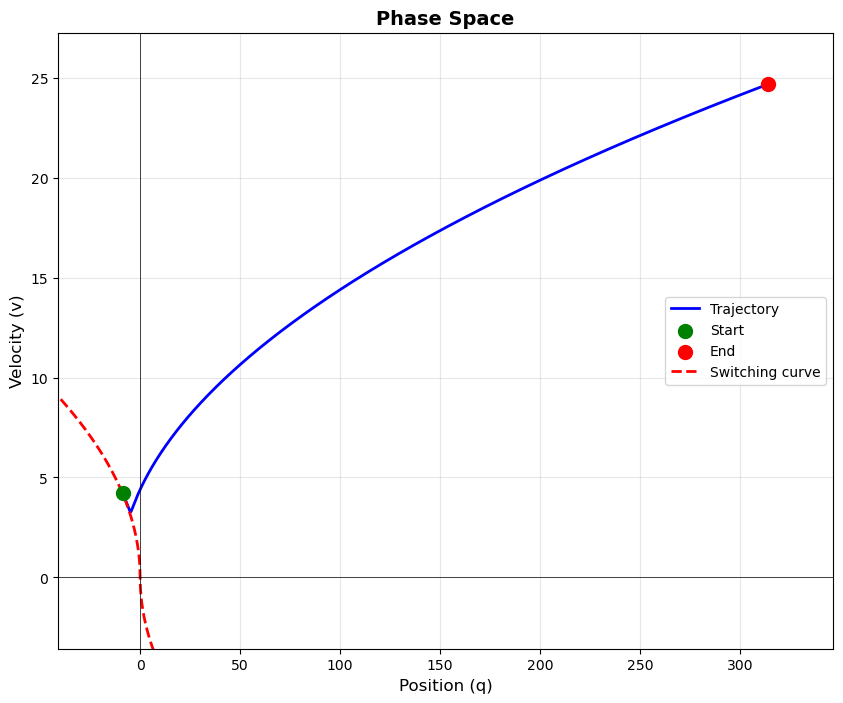

In [258]:
time_got = switching_time_benchmark(init_pos, init_vel)
time_ref = switching_time.view(-1)
print(switching_time_benchmark(init_pos, init_vel))
print(switching_time.view(-1))
print(f"Average switching time error for last batch is: {torch.abs(time_got - time_ref)}")
bad_ind = torch.argmax(torch.abs(time_got - time_ref))

import matplotlib.pyplot as plt

b = bad_ind

fig, ax1 = plt.subplots(figsize=(10, 8))
pos = history_pos[b].detach().numpy()
vel = history_vel[b].detach().numpy()

x_min, x_max = pos.min(), pos.max()
y_min, y_max = vel.min(), vel.max()

x_min = min(x_min, -1.0)  # At least show -1 if everything is positive
x_max = max(x_max, 1.0)   # At least show +1 if everything is negative
y_min = min(y_min, -1.0)
y_max = max(y_max, 1.0)

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax1.set_xlim(x_min - x_margin, x_max + x_margin)
ax1.set_ylim(y_min - y_margin, y_max + y_margin)

ax1.plot(pos, vel, 'b-', linewidth=2, label='Trajectory')
ax1.scatter(pos[0], vel[0], color='green', s=100, zorder=5, label='Start')
ax1.scatter(pos[-1], vel[-1], color='red', s=100, zorder=5, label='End')

# 스위칭 곡선: v^2/2 + q = 0 => q = -v^2/2
v_switch = np.linspace(-15, 15, 500)
q_switch = -v_switch * np.abs(v_switch) / 2
ax1.plot(q_switch, v_switch, 'r--', linewidth=2, label='Switching curve')

ax1.set_xlabel('Position (q)', fontsize=12)
ax1.set_ylabel('Velocity (v)', fontsize=12)
ax1.set_title('Phase Space', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
plt.show()